In [1]:
import keras
import keras.backend as K
from keras.datasets import mnist
from keras.models import Sequential, Model, load_model
from keras.layers import Dense, Dropout, Activation, Flatten, Input, Lambda
from keras.layers import Conv2D, MaxPooling2D, AveragePooling2D, Conv1D, MaxPooling1D, LSTM, ConvLSTM2D, GRU, BatchNormalization, LocallyConnected2D, Permute, TimeDistributed, Bidirectional
from keras.layers import Concatenate, Reshape, Conv2DTranspose, Embedding, Multiply, Activation

import tensorflow as tf

from functools import partial

from collections import defaultdict

import os
import pickle
import numpy as np

import pandas as pd

import scipy.sparse as sp
import scipy.io as spio

class TempSequence :
    def __init__(self) :
        self.temp1 = 1

keras.utils.Sequence = TempSequence

import isolearn.io as isoio
import isolearn.keras as isol

import matplotlib.pyplot as plt

from sequence_logo_helper import dna_letter_at, plot_dna_logo


Using TensorFlow backend.


In [2]:
#Define dataset/experiment name
dataset_name = "optimus5_synthetic_if_uorf_1_start_2_stop_variable_loc"

def one_hot_encode(df, col='utr', seq_len=50):
    # Dictionary returning one-hot encoding of nucleotides. 
    nuc_d = {'a':[1,0,0,0],'c':[0,1,0,0],'g':[0,0,1,0],'t':[0,0,0,1], 'n':[0,0,0,0]}
    
    # Creat empty matrix.
    vectors=np.empty([len(df),seq_len,4])
    
    # Iterate through UTRs and one-hot encode
    for i,seq in enumerate(df[col].str[:seq_len]): 
        seq = seq.lower()
        a = np.array([nuc_d[x] for x in seq])
        vectors[i] = a
    return vectors

def one_hot_encode_gt(df, col='gt', seq_len=50):
    # Dictionary returning one-hot encoding of nucleotides. 
    nuc_d = {'n':[1,0,0,0,0,0,0],'a':[0,1,0,0,0,0,0],'b':[0,0,1,0,0,0,0],'c':[0,0,0,1,0,0,0],'x':[0,0,0,0,1,0,0],'y':[0,0,0,0,0,1,0],'z':[0,0,0,0,0,0,1]}
    
    # Creat empty matrix.
    vectors=np.empty([len(df),seq_len,7])
    
    # Iterate through UTRs and one-hot encode
    for i,seq in enumerate(df[col].str[:seq_len]): 
        seq = seq.lower()
        a = np.array([nuc_d[x] for x in seq])
        vectors[i] = a
    return vectors

#Train data
df_train = pd.read_csv("bottom5KIFuAUGTop5KIFuAUG.csv")
x_train = np.expand_dims(one_hot_encode(df_train), axis=1)

#Test data
df_test = pd.read_csv("optimus5_synthetic_if_uorf_1_start_2_stop_variable_loc.csv")
x_test = np.expand_dims(one_hot_encode(df_test), axis=1)
y_test = one_hot_encode_gt(df_test)

print("x_train.shape = " + str(x_train.shape))
print("x_test.shape = " + str(x_test.shape))
print("y_test.shape = " + str(y_test.shape))


x_train.shape = (15008, 1, 50, 4)
x_test.shape = (512, 1, 50, 4)
y_test.shape = (512, 50, 7)


In [3]:
#Define sequence template (APA Doubledope sublibrary)

sequence_template = 'N' * 50

sequence_mask = np.array([1 if sequence_template[j] == 'N' else 0 for j in range(len(sequence_template))])


In [4]:
#Visualize background sequence distribution

pseudo_count = 1.0

x_mean = (np.sum(x_train, axis=(0, 1)) + pseudo_count) / (x_train.shape[0] + 4. * pseudo_count)
x_mean_logits = np.log(x_mean / (1. - x_mean))


In [5]:
#Load Predictor
predictor_path = 'optimusRetrainedMain.hdf5'

predictor_temp = load_model(predictor_path)

predictor_temp.trainable = False
predictor_temp.compile(optimizer=keras.optimizers.SGD(lr=0.1), loss='mean_squared_error')

predictor_temp.summary()


Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
Instructions for updating:
Use tf.cast instead.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_1 (Conv1D)            (None, 50, 120)           3960      
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 50, 120)           115320    
_________________________________________________________________
dropout_1 (Dropout)          (None, 50, 120)           0         
_________________________________________________________________
conv1d_3 (Conv1D)            (None, 50, 120)           115320    
_________________________________________________________________
dropout_2 (Dropout)          (None, 50, 120)           0         
_______________________________________

In [6]:
#Optimus5 parameters
seq_input_shape = (1, 50, 4)

#Inputs
seq_input = Input(shape=seq_input_shape)

permute_layer = Lambda(lambda x: x[:, 0, ...])

predictor = Model(
    inputs=seq_input,
    outputs=[
        predictor_temp([permute_layer(seq_input)])
    ]
)

predictor.trainable = False

predictor.compile(
    optimizer=keras.optimizers.SGD(lr=0.1),
    loss='mean_squared_error'
)


In [7]:
from tensorflow.python.framework import ops

#Stochastic Binarized Neuron helper functions (Tensorflow)
#ST Estimator code adopted from https://r2rt.com/beyond-binary-ternary-and-one-hot-neurons.html
#See Github https://github.com/spitis/

def st_sampled_softmax(logits):
    with ops.name_scope("STSampledSoftmax") as namescope :
        nt_probs = tf.nn.softmax(logits)
        onehot_dim = logits.get_shape().as_list()[1]
        sampled_onehot = tf.one_hot(tf.squeeze(tf.multinomial(logits, 1), 1), onehot_dim, 1.0, 0.0)
        with tf.get_default_graph().gradient_override_map({'Ceil': 'Identity', 'Mul': 'STMul'}):
            return tf.ceil(sampled_onehot * nt_probs)

def st_hardmax_softmax(logits):
    with ops.name_scope("STHardmaxSoftmax") as namescope :
        nt_probs = tf.nn.softmax(logits)
        onehot_dim = logits.get_shape().as_list()[1]
        sampled_onehot = tf.one_hot(tf.argmax(nt_probs, 1), onehot_dim, 1.0, 0.0)
        with tf.get_default_graph().gradient_override_map({'Ceil': 'Identity', 'Mul': 'STMul'}):
            return tf.ceil(sampled_onehot * nt_probs)

@ops.RegisterGradient("STMul")
def st_mul(op, grad):
    return [grad, grad]

#Gumbel Distribution Sampler
def gumbel_softmax(logits, temperature=0.5) :
    gumbel_dist = tf.contrib.distributions.RelaxedOneHotCategorical(temperature, logits=logits)
    batch_dim = logits.get_shape().as_list()[0]
    onehot_dim = logits.get_shape().as_list()[1]
    return gumbel_dist.sample()


In [8]:

def mask_dropout_multi_scale(mask, drop_scales=[1, 2, 4, 7], min_drop_rate=0.0, max_drop_rate=0.5) :
    
    rates = K.random_uniform(shape=(K.shape(mask)[0], 1, 1, 1), minval=min_drop_rate, maxval=max_drop_rate)
    
    scale_logits = K.random_uniform(shape=(K.shape(mask)[0], len(drop_scales), 1, 1, 1), minval=-5., maxval=5.)
    scale_probs = K.softmax(scale_logits, axis=1)
    
    ret_mask = mask
    for drop_scale_ix, drop_scale in enumerate(drop_scales) :
        ret_mask = mask_dropout(ret_mask, rates * scale_probs[:, drop_scale_ix, ...], drop_scale=drop_scale)
    
    return K.switch(K.learning_phase(), ret_mask, mask)

def mask_dropout(mask, drop_rates, drop_scale=1) :
    
    random_tensor_downsampled = K.random_uniform(shape=(
        K.shape(mask)[0],
        1,
        K.cast(K.shape(mask)[2] / drop_scale, dtype=tf.int32),
        K.shape(mask)[3]
    ), minval=0.0, maxval=1.0)
    
    keep_mask_downsampled = random_tensor_downsampled >= drop_rates
    
    keep_mask = K.repeat_elements(keep_mask_downsampled, rep=drop_scale, axis=2)
    
    ret_mask = mask * K.cast(keep_mask, dtype=tf.float32)
    
    return ret_mask

def mask_dropout_single_scale(mask, drop_scale=1, min_drop_rate=0.0, max_drop_rate=0.5) :
    
    rates = K.random_uniform(shape=(K.shape(mask)[0], 1, 1, 1), minval=min_drop_rate, maxval=max_drop_rate)
    
    random_tensor_downsampled = K.random_uniform(shape=(
        K.shape(mask)[0],
        1,
        K.cast(K.shape(mask)[2] / drop_scale, dtype=tf.int32),
        K.shape(mask)[3]
    ), minval=0.0, maxval=1.0)
    
    keep_mask_downsampled = random_tensor_downsampled >= rates
    
    keep_mask = K.repeat_elements(keep_mask_downsampled, rep=drop_scale, axis=2)
    
    ret_mask = mask * K.cast(keep_mask, dtype=tf.float32)
    
    return K.switch(K.learning_phase(), ret_mask, mask)


In [9]:
#Load models
save_dir = 'saved_models'

if not os.path.isdir(save_dir):
    os.makedirs(save_dir)

model_name = "autoscrambler_dataset_egfp_unmod_1_sample_mode_gumbel_n_samples_32_resnet_5_4_32_3_00_00_to_015_n_epochs_50_target_bits_0125_example_if_uorf_seqs_drop_multi_scale_weight_1"

model_path = os.path.join(save_dir, model_name + '.h5')
scrambler_model = load_model(model_path, custom_objects = {
    "mask_dropout_multi_scale" : mask_dropout_multi_scale,
    "tf" : tf,
    "gumbel_softmax" : gumbel_softmax
})

print('Loaded scrambler model %s ' % (model_path))



For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
If you depend on functionality not listed there, please file an issue.

Instructions for updating:
The TensorFlow Distributions library has moved to TensorFlow Probability (https://github.com/tensorflow/probability). You should update all references to use `tfp.distributions` instead of `tf.contrib.distributions`.
Instructions for updating:
The TensorFlow Distributions library has moved to TensorFlow Probability (https://github.com/tensorflow/probability). You should update all references to use `tfp.distributions` instead of `tf.contrib.distributions`.
Instructions for updating:
The TensorFlow Distributions library has moved to TensorFlow Probability (https://github.com/tensorflow/probability). You should update all references to use `tfp.distributions` instead of `tf.distributions`.
Instructions for updating:
The TensorFlo

In [10]:

s_test = np.zeros((x_test.shape[0], 1))

all_ones_mask_test = np.ones((x_test.shape[0], 1, 50, 1))

_, pwm_test, sample_test, importance_scores_test = scrambler_model.predict(x=[x_test, all_ones_mask_test, s_test], batch_size=32, verbose=True)

importance_scores_test = np.tile(importance_scores_test, (1, 1, 1, 4)) * x_test

print(importance_scores_test.shape)


512/512 [==============================] - 3s 5ms/step
(512, 1, 50, 4)


In [11]:
#Gradient saliency/backprop visualization

import matplotlib.collections as collections
import operator
import matplotlib.pyplot as plt

import matplotlib.cm as cm
import matplotlib.colors as colors

import matplotlib as mpl
from matplotlib.text import TextPath
from matplotlib.patches import PathPatch, Rectangle
from matplotlib.font_manager import FontProperties
from matplotlib import gridspec
from matplotlib.ticker import FormatStrFormatter

def plot_importance_scores(importance_scores, ref_seq, figsize=(12, 2), score_clip=None, sequence_template='', plot_start=0, plot_end=96) :

    end_pos = ref_seq.find("#")
    
    fig = plt.figure(figsize=figsize)
    
    ax = plt.gca()
    
    if score_clip is not None :
        importance_scores = np.clip(np.copy(importance_scores), -score_clip, score_clip)
    
    max_score = np.max(np.sum(importance_scores[:, :], axis=0)) + 0.01

    for i in range(0, len(ref_seq)) :
        mutability_score = np.sum(importance_scores[:, i])
        dna_letter_at(ref_seq[i], i + 0.5, 0, mutability_score, ax)

    plt.sca(ax)
    plt.xlim((0, len(ref_seq)))
    plt.ylim((0, max_score))
    plt.axis('off')
    plt.yticks([0.0, max_score], [0.0, max_score], fontsize=16)

    for axis in fig.axes :
        axis.get_xaxis().set_visible(False)
        axis.get_yaxis().set_visible(False)
    
    plt.tight_layout()
    
    plt.show()


Test sequence 0:


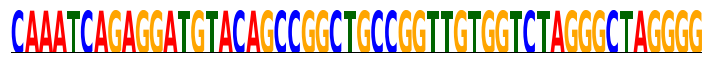

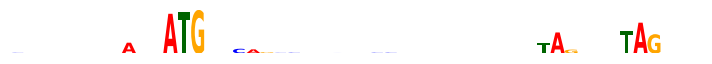

Test sequence 1:


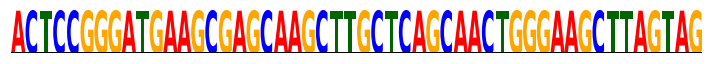

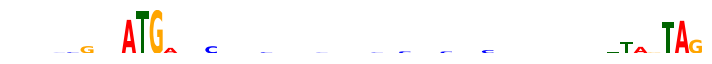

Test sequence 2:


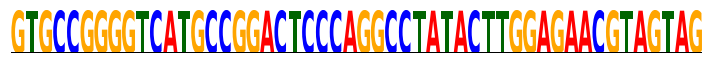

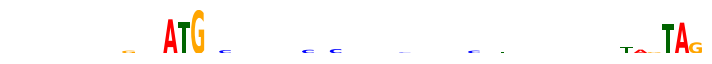

Test sequence 3:


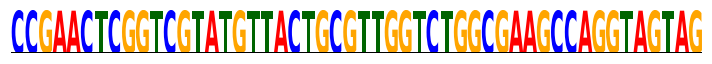

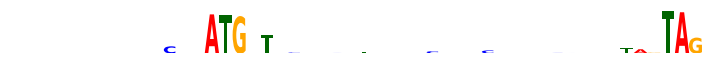

Test sequence 4:


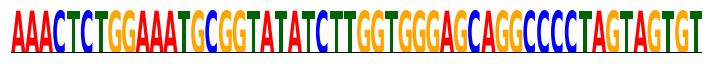

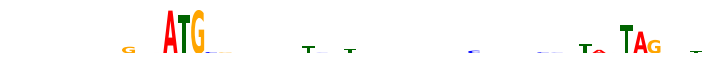

Test sequence 5:


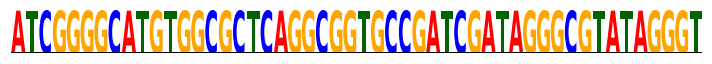

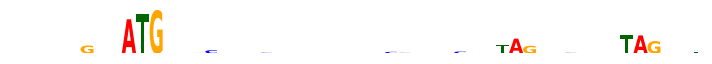

Test sequence 6:


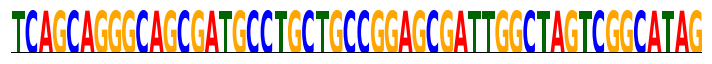

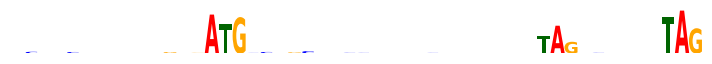

Test sequence 7:


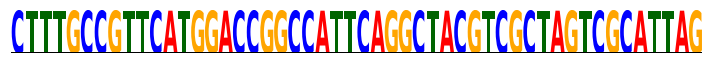

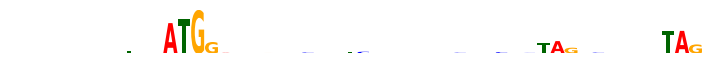

Test sequence 8:


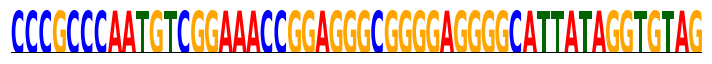

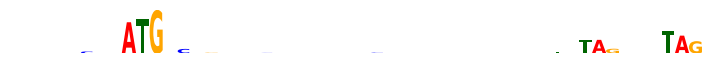

Test sequence 9:


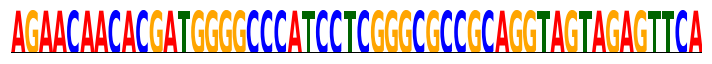

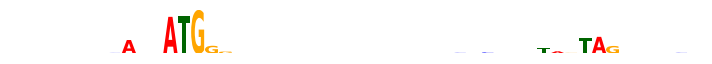

In [12]:
#Visualize a few perturbations

encoder = isol.OneHotEncoder(50)

score_clip = None#0.5

for plot_i in range(0, 10) :

    print("Test sequence " + str(plot_i) + ":")

    plot_dna_logo(x_test[plot_i, 0, :, :], sequence_template=sequence_template, figsize=(10, 1), plot_start=0, plot_end=50)
    plot_importance_scores(importance_scores_test[plot_i, 0, :, :].T, encoder.decode(x_test[plot_i, 0, :, :]), figsize=(10, 1), score_clip=score_clip, sequence_template=sequence_template, plot_start=0, plot_end=50)


In [13]:
#Save predicted importance scores

model_name = "scrambler_" + dataset_name

np.save(model_name + "_importance_scores_test", importance_scores_test)


In [14]:
#Calculate NAND reconstruction accuracy

nts = 6

scores_test = np.sum(importance_scores_test, axis=(1, 3))

accs = []

for i in range(x_test.shape[0]) :
    top_ix = np.argsort(scores_test[i, :])[::-1][:nts]
    
    #Start A
    start_cover_a = np.sum(y_test[i, top_ix, 1])
    
    #Stop X
    stop_cover_x = np.sum(y_test[i, top_ix, 4])
    
    #Stop Y
    stop_cover_y = np.sum(y_test[i, top_ix, 5])
    
    if start_cover_a >= 3 and (stop_cover_x >= 3 or stop_cover_y >= 3) :
        accs.append(1.)
    else :
        accs.append(0.)

accs = np.array(accs)


In [15]:
print("Logic Function Reconstruction Accuracy = " + str(round(np.mean(accs), 3)))

Logic Function Reconstruction Accuracy = 0.484


In [16]:
#Calculate operand importance metrics

operand_scores = y_test * np.tile(np.expand_dims(scores_test, axis=-1), (1, 1, y_test.shape[2]))

bg_scores = []
start_scores = []
stop_scores = []

for i in range(x_test.shape[0]) :
    #Bg
    for j in range(operand_scores.shape[1]) :
        if y_test[i, j, 0] >= 1 :
            bg_scores.append(operand_scores[i, j, 0])
    
    #Start A
    for j in range(operand_scores.shape[1]) :
        if y_test[i, j, 1] >= 1 :
            start_scores.append(operand_scores[i, j, 1])
    
    if np.sum(operand_scores[i, :, 4]) > np.sum(operand_scores[i, :, 5]) : #max of stops
        #Stop X
        for j in range(operand_scores.shape[1]) :
            if y_test[i, j, 4] >= 1 :
                stop_scores.append(operand_scores[i, j, 4])
    else :
        #Stop Y
        for j in range(operand_scores.shape[1]) :
            if y_test[i, j, 5] >= 1 :
                stop_scores.append(operand_scores[i, j, 5])

bg_scores = np.array(bg_scores)
start_scores = np.array(start_scores)
stop_scores = np.array(stop_scores)

np.random.shuffle(bg_scores)
np.random.shuffle(start_scores)
np.random.shuffle(stop_scores)


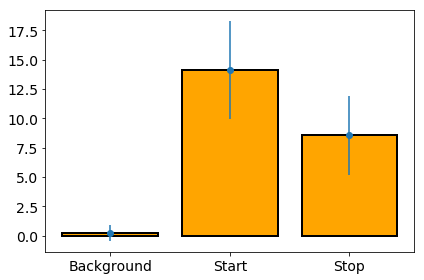

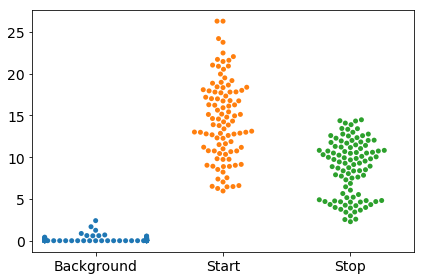

In [17]:
#Plot importance metrics

mean_bg = np.mean(bg_scores)
mean_start = np.mean(start_scores)
mean_stop = np.mean(stop_scores)

std_bg = np.std(bg_scores)
std_start = np.std(start_scores)
std_stop = np.std(stop_scores)

f = plt.figure(figsize=(6, 4))

plt.bar([0, 1, 2], [mean_bg, mean_start, mean_stop], edgecolor='black', linewidth=2, color='orange')

plt.errorbar([0, 1, 2], [mean_bg, mean_start, mean_stop], fmt='o', yerr=[std_bg, std_start, std_stop])

plt.xticks([0, 1, 2], ["Background", "Start", "Stop"], fontsize=14)
plt.yticks(fontsize=14)

plt.tight_layout()

plt.show()


import seaborn as sns

f = plt.figure(figsize=(6, 4))

sns.swarmplot(data=[bg_scores[:100], start_scores[:100], stop_scores[:100]])

plt.xticks([0, 1, 2], ["Background", "Start", "Stop"], fontsize=14)
plt.yticks(fontsize=14)

plt.tight_layout()

plt.show()
